# Digit Recognizer

### Import Dependencies

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
%matplotlib inline

import random

random.seed(1)
import csv

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
config = tf.ConfigProto(log_device_placement=True)
config.gpu_options.allow_growth=True
config.gpu_options.per_process_gpu_memory_fraction = 0.3
# sess = tf.Session(config=config)

### Preparing Data

In [4]:
data = pd.read_csv('train.csv')
train, dev = train_test_split(data, test_size=0.25,random_state=0, stratify=data['label'])
print(train.shape, dev.shape)

(31500, 785) (10500, 785)


In [5]:
Y_train = train.iloc[:, 0].as_matrix()
Y_train = np.eye(10, dtype='float32')[Y_train] 
#it's imp to specify dtype, as default is float64, but placeholder expects float32.
X_train = train.iloc[:,1:].as_matrix().astype('float32')

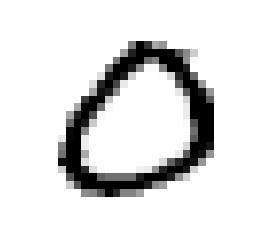

In [6]:
index = 1057
img = X_train[index].reshape(28, 28)
plt.axis('off')
plt.imshow(img, cmap=cm.binary)

In [7]:
Y_dev = dev.iloc[:, 0].as_matrix()
Y_dev = np.eye(10, dtype='float32')[Y_dev]
X_dev = dev.iloc[:,1:].as_matrix().astype('float32')

In [8]:
X_test = pd.read_csv('test.csv').as_matrix().astype('float32')
X_test = np.multiply(X_test, 1.0/255.0)

In [9]:
X_train = np.multiply(X_train, 1.0/255.0)
X_dev = np.multiply(X_dev, 1.0/255.0)

In [10]:
print(X_train.shape)
print(X_dev.shape)
print(mnist.train.images.shape, mnist.test.images.shape)
print(X_test.shape)


(31500, 784)
(10500, 784)
(55000, 784) (10000, 784)
(28000, 784)


In [11]:
# dataset = tf.data.Dataset.from_tensor_slices(X_train)

In [12]:
def get_next_batch(initial, batch_size, X, Y):
    i = initial * batch_size
    j = i + batch_size
    return X[i:j], Y[i:j]

### Build Computation Graph

#### CNN implementation


In [24]:
class Model:
    def __init__(self, _num_epochs):
        # set hyperparameters
        self.learning_rate = 0.0001
        self.minibatch_size = 100 #check X_train and X_dev size before changing this
        self.num_epochs = _num_epochs
        self.graph = tf.Graph()
        with self.graph.as_default():

            # initialize placeholders
            self.X = tf.placeholder(tf.float32, [None, 784], name='X')
            self.Y = tf.placeholder(tf.int32, [None, 10], name='Y')
            self.keep_prob = tf.placeholder(tf.float32, name='keep_prob')
            # initialize weights
            self.W1 = tf.get_variable('W1', [5, 5, 1, 32], 
                                      initializer=tf.contrib.layers.xavier_initializer(seed=0))
            self.b1 = tf.Variable(tf.constant(0., shape=[32]), name='b1')
            self.W2 = tf.get_variable('W2', [5, 5, 32, 64], 
                                      initializer= tf.contrib.layers.xavier_initializer(seed=0))
            self.b2 = tf.Variable(tf.constant(0., shape=[64]), name='b2')
            self.W3 = tf.get_variable('W3', [7 * 7 * 64, 1024], 
                                      initializer= tf.contrib.layers.xavier_initializer(seed=0))
            self.b3 = tf.Variable(tf.constant(0., shape=[1024]), name='b3')
            self.W4 = tf.get_variable('W4', [1024, 10], 
                                      initializer= tf.contrib.layers.xavier_initializer(seed=0))
            self.b4 = tf.Variable(tf.constant(0., shape=[10]), name='b4')
            # forward propogation
            self.x_image = tf.reshape(self.X, [-1, 28, 28, 1])

            self.Z1 = tf.nn.conv2d(self.x_image, self.W1, strides=[1, 1, 1, 1], padding='SAME')
            self.A1 = tf.nn.relu(self.Z1 + self.b1)
            self.h_pool1 = tf.nn.max_pool(self.A1, ksize=[1, 2, 2, 1],
                                strides=[1, 2, 2, 1], padding='SAME')

            self.Z2 = tf.nn.conv2d(self.h_pool1, self.W2, strides=[1, 1, 1, 1], padding='SAME')
            self.A2 = tf.nn.relu(self.Z2 + self.b2)
            self.h_pool2 = tf.nn.max_pool(self.A2, ksize=[1, 2, 2, 1],
                                strides=[1, 2, 2, 1], padding='SAME')

            self.h_pool2_flat = tf.reshape(self.h_pool2, [-1, 7*7*64])
            self.h_fc1 = tf.nn.relu(tf.matmul(self.h_pool2_flat, self.W3) + self.b3)

            self.h_fc1_drop = tf.nn.dropout(self.h_fc1, self.keep_prob)
            self.Y_conv = tf.matmul(self.h_fc1_drop, self.W4) + self.b4

            # cost computation
            self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
                                                                    logits=self.Y_conv,
                                                                    labels=self.Y), 
                                                                   name='cost')
            # optimizer
            self.optimizer = tf.train.AdamOptimizer(self.learning_rate).minimize(self.cost)
            # accuracy prediction
            self.correct_prediction = tf.equal(tf.argmax(self.Y, 1), tf.argmax(self.Y_conv, 1))
            self.accuracy = tf.reduce_mean(tf.cast(self.correct_prediction, tf.float32))
            self.saver = tf.train.Saver()
            self.sess = tf.Session(config=config, graph=self.graph)
#             writer = tf.summary.FileWriter("output", model.sess.graph)
#             writer.close()

        
    def train(self, X_train, Y_train, X_dev, Y_dev, X_test):
        self.sess.run(tf.global_variables_initializer())
        costs_epoch_wise = []
        costs = []
        num_minibatches = X_train.shape[0] // self.minibatch_size
        for epoch in range(self.num_epochs+1):
            epoch_cost = 0 
            for initial in range(num_minibatches):
                batch_xs, batch_ys = get_next_batch(initial, self.minibatch_size,
                                                    X_train, Y_train)
                _, c = self.sess.run([self.optimizer, self.cost], feed_dict={
                                                                    self.X: batch_xs,
                                                                   self.Y: batch_ys,
                                                                  self.keep_prob:0.5})
                epoch_cost += c
                costs.append(c/num_minibatches)
            epoch_cost /= num_minibatches
            costs_epoch_wise.append(epoch_cost)
            if(epoch%5==0): print('Epoch:', epoch, 'Cost', epoch_cost)

        plt.plot(np.squeeze(costs[300:]))
        plt.show()
        plt.plot(np.squeeze(costs_epoch_wise[5:]))
        plt.show()

        train_accuracy = self.get_accuracy(X_train, Y_train) 

        dev_accuracy = self.get_accuracy(X_dev, Y_dev) 

        mnist_test_accuracy = self.get_accuracy(mnist.test.images, mnist.test.labels) 

        print('Train set accuracy %0.4f' % train_accuracy)
        print('Dev set accuracy %0.4f' % dev_accuracy)
        print('mnist test accuracy %g' % mnist_test_accuracy)

        Y_predicted = self.predict(X_test)
        return np.squeeze(Y_predicted).astype('int')
        
    def get_accuracy(self, X_data, Y_data):
        acc = 0
        num_minibatches = X_data.shape[0] // self.minibatch_size
        for initial in range(num_minibatches):
            batch_xs, batch_ys = get_next_batch(initial, self.minibatch_size, X_data, Y_data)
            acc += self.sess.run(self.accuracy, feed_dict={self.X:batch_xs, self.Y:batch_ys,
                                                           self.keep_prob:1.0})

        return acc/num_minibatches

        
    def predict(self, X_test):
        m = X_test.shape[0]
        Y_predicted = np.random.randn(m,1)
        for k in range(0, m//500):
            i = k * 500
            j = i + 500
            Y_predicted[i:j, 0] = self.sess.run(tf.argmax(self.Y_conv, 1), feed_dict = {
                                                                    self.X: X_test[i:j],
                                                                    self.keep_prob:1.0})
        return Y_predicted


    def get_mislabeled(self, X_data, Y_data):
        Y_predicted = self.predict(X_data)
        mistakes = tf.not_equal(tf.argmax(Y_data, 1), tf.argmax(self.Y_predicted, 1))
        indices = [x for x,y in mistakes if y==True]
        return indices
        
    def restore_model(self, model_path):
        self.saver.restore(self.sess, model_path)
        print('Model restored from %s' % model_path)
        
    def save_model(self, model_path):
        self.saver.save(self.sess, model_path)
        print('Model saved at %s' % model_path)


### Train and Test the model

In [14]:
%%time
tf.reset_default_graph()
num_epochs = 50
model = Model(num_epochs)
# Y_predicted = model.train(X_train, Y_train, X_dev, Y_dev, X_test)

CPU times: user 306 ms, sys: 19.9 ms, total: 326 ms
Wall time: 323 ms


In [15]:
path = 'models/e50cpu.ckpt'
model.restore_model(path)

INFO:tensorflow:Restoring parameters from models/e50cpu.ckpt


### Prediction on kaggle dev data set

In [16]:
def get_mistakes(Y_data, Y_data_prediction):
    mistakes = np.not_equal(np.argmax(Y_data, 1), np.argmax(Y_data_prediction, 1))
    indices = [x for x,y in enumerate(mistakes) if y==True]
    return indices

In [17]:
Y_train_prediction = model.sess.run(model.Y_conv, feed_dict={model.X:X_train, model.keep_prob:1.0})
train_mistaken_indices = get_mistakes(Y_train, Y_train_prediction)
Y_dev_prediction = model.sess.run(model.Y_conv, feed_dict={model.X:X_dev, model.keep_prob:1.0})
dev_mistaken_indices = get_mistakes(Y_dev, Y_dev_prediction)

print('Total mislabeld images in Train set', len(train_mistaken_indices))
print('Total mislabeld images in dev set', len(dev_mistaken_indices))


Total mislabeld images in Train set 6
Total mislabeld images in dev set 107


### Model analysis

5 Epocs, CPU compute-2
   
    Total mislabeld images in Train set 225
    Total mislabeld images in dev set 167
    
50 Epochs, CPU compute-2

    Train set accuracy 0.9997
    Dev set accuracy 0.9890
    mnist test accuracy 0.9953
    Epoch: 50 Cost 0.00279164741919

    CPU times: user 2h 45min 4s, sys: 7min 40s, total: 2h 52min 44s
    Wall time: 11min 42s
    Total mislabeld images in Train set 10
    Total mislabeld images in dev set 115    
    model: models/e50cpu.ckpt

In [18]:
# save_path = model.saver.save(model.sess, "models/e50cpu.ckpt")

In [25]:
def plot_img(index, X_data, Y_data, predicted_Y_data):
    pixels = X_data[index]
    label = np.argmax(Y_data[index])
    plabel = np.argmax(predicted_Y_data[index])
    # Reshape the array into 28 x 28 array (2-dimensional array)
    pixels = pixels.reshape((28, 28))

    # Plot
    plt.title('Label is {}, predicted {}'.format(label, plabel), color='w')
    plt.imshow(pixels, cmap=cm.binary)
    plt.axis('off')
    plt.show()
    

In [26]:
def show_all(indices, X_data, Y_data, predicted_Y_data):
    plt.figure(figsize=(100, 100))
    rows, cols = int(np.ceil(len(indices)/10)), 10
    for i in range(rows * cols):
        plt.subplot(rows, cols, i + 1)
        try:
            j = indices[i]
            img = np.reshape(X_data[j], (28, 28))
            label = np.argmax(Y_data[j])
            plabel = np.argmax(predicted_Y_data[j])
            plt.imshow(img, cmap=cm.binary)
            plt.title('{}, {}'.format(label, plabel), color='w', fontsize=100)
            plt.axis('off')
        except:
            pass
    plt.tight_layout()
#     plt.savefig('cifar_examples.png')


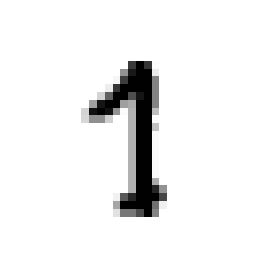

In [27]:
index = random.choice(train_mistaken_indices)
plot_img(index, X_train, Y_train, Y_train_prediction)

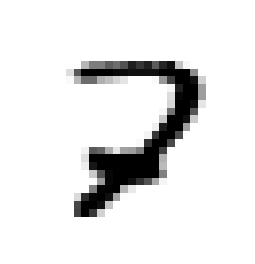

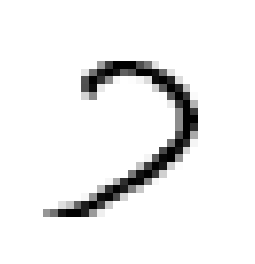

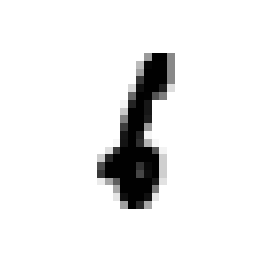

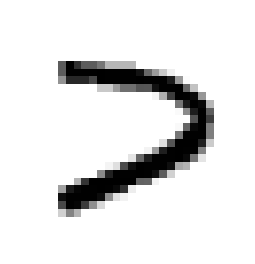

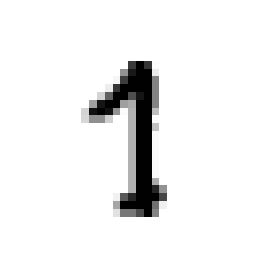

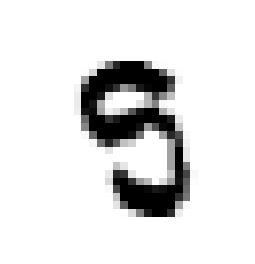

In [28]:
for i in train_mistaken_indices:
    plot_img(i, X_train, Y_train, Y_train_prediction)

In [29]:
show_all(dev_mistaken_indices, X_dev, Y_dev, Y_dev_prediction)

In [ ]:
# with open('submission-cnn.csv', 'w') as file:
#     writer = csv.writer(file)
#     writer.writerow(['ImageId', 'Label'])
#     for i in range(Y_predicted.shape[0]):
#         writer.writerow([i+1, Y_predicted[i]])